In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer

from data import tfrecord_labeled_dataset, tfrecord_dataset, train_test_split, kfolds
from layers import SeluConv3D, SeluDense
from plot import plot_volume_animation, plot_loss_history, plot_regression_results
from config import (
    CT_0_TFRECORD,
    CT_1_TFRECORD,
    CT_2_TFRECORD,
    CT_3_TFRECORD,
    CT_4_TFRECORD,
    COVID_NEG_TFRECORD,
    COVID_POS_TFRECORD,
    SCAN_SHAPE,
    LIDC_NUM_NODULES_TFRECORD,
)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]
matplotlib.rcParams.update({"font.size": 15})

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# LIDC dataset

In [2]:
def scaler(x, label):
    def numpy_transform(x):
        qt = QuantileTransformer()
        raw = qt.fit_transform(x.reshape((-1, 1))).reshape(x.shape)
        return 1 / (1 + np.exp(-(raw - 0.7) / 0.2))

    scaled_x = tf.numpy_function(numpy_transform, [x], tf.float32)
    scaled_x.set_shape(SCAN_SHAPE)
    return scaled_x, label

In [3]:
"""
Load the LIDC dataset. Its elements are of the form:
    (scan, number_of_nodules)

Where scan is a 3D volume of size (64, 192, 224, 1)
"""
lidc_dataset = tfrecord_labeled_dataset(LIDC_NUM_NODULES_TFRECORD)
# lidc_dataset = lidc_dataset.map(scaler, num_parallel_calls=tf.data.experimental.AUTOTUNE)
lidc_samples = sum(1 for _ in tqdm(lidc_dataset))
# lidc_samples = 571
print(f"{lidc_samples = }")
lidc_dataset


lidc_samples = 797


<ParallelMapDataset shapes: ((None, None, None, None), (1,)), types: (tf.float32, tf.uint16)>

In [ ]:
"""
Run this to have an idea of the elements of the lidc_dataset.
"""
scan, num_nodules = next(iter(lidc_dataset))
print(f"{num_nodules = }")
print(scan.shape)
plot_volume_animation(scan)

num_nodules = <tf.Tensor: shape=(1,), dtype=uint16, numpy=array([1], dtype=uint16)>
(112, 192, 224, 1)


In [16]:
def build_regression_model():
    model = keras.Sequential(
        [
            keras.layers.InputLayer(SCAN_SHAPE, name="input_layer"),
            SeluConv3D(filters=32, kernel_size=3, name="selu_conv3d_1"),
            keras.layers.MaxPool3D(2, name="maxpool3d_1"),
            SeluConv3D(filters=64, kernel_size=3, name="selu_conv3d_2"),
            keras.layers.MaxPool3D(2, name="maxpool3d_2"),
            SeluConv3D(filters=128, kernel_size=3, name="selu_conv3d_3"),
            keras.layers.MaxPool3D(2, name="maxpool3d_3"),
            SeluConv3D(filters=256, kernel_size=3, name="selu_conv3d_4"),
            keras.layers.MaxPool3D(2, name="maxpool3d_4"),
            keras.layers.Flatten(name="flatten"),
            keras.layers.Dense(1, name="final_dense"),
        ],
        name="3d_cnn",
    )
    return model


m = build_regression_model()
m.summary()

Model: "3d_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
selu_conv3d_1 (Conv3D)       (None, 64, 192, 224, 32)  896       
_________________________________________________________________
maxpool3d_1 (MaxPooling3D)   (None, 32, 96, 112, 32)   0         
_________________________________________________________________
selu_conv3d_2 (Conv3D)       (None, 32, 96, 112, 64)   55360     
_________________________________________________________________
maxpool3d_2 (MaxPooling3D)   (None, 16, 48, 56, 64)    0         
_________________________________________________________________
selu_conv3d_3 (Conv3D)       (None, 16, 48, 56, 128)   221312    
_________________________________________________________________
maxpool3d_3 (MaxPooling3D)   (None, 8, 24, 28, 128)    0         
_________________________________________________________________
selu_conv3d_4 (Conv3D)       (None, 8, 24, 28, 256)    88499

In [17]:
val_perc = 0.2
learning_rate = 1e-5
batch_size = 16
patience = 15

In [26]:
train_dataset, val_dataset = train_test_split(
    lidc_dataset, test_perc=val_perc, cardinality=lidc_samples
)
val_dataset = (
    val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset = (
    train_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [27]:
"""
Train a regression model for the number of nodules on the LIDC dataset.
Save the final model in models/lidc-num-nodules-3dcnn.h5
"""
cnn = build_regression_model()
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.MeanSquaredError(),
)
history = cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True,
        ),
    ],
)
cnn.save("models/lidc-num-nodules-3dcnn.h5")

Epoch 1/1000
29/29 [==============================] - 126s 4s/step - loss: 526.7267 - val_loss: 639.5596
Epoch 2/1000
29/29 [==============================] - 23s 788ms/step - loss: 412.5575 - val_loss: 651.7043
Epoch 3/1000
29/29 [==============================] - 23s 790ms/step - loss: 405.0018 - val_loss: 636.3668
Epoch 4/1000
29/29 [==============================] - 23s 794ms/step - loss: 407.9239 - val_loss: 650.9857
Epoch 5/1000
29/29 [==============================] - 23s 798ms/step - loss: 403.4880 - val_loss: 641.9758
Epoch 6/1000
29/29 [==============================] - 23s 796ms/step - loss: 396.7353 - val_loss: 646.7423
Epoch 7/1000
29/29 [==============================] - 23s 798ms/step - loss: 394.6893 - val_loss: 632.5609
Epoch 8/1000
29/29 [==============================] - 23s 795ms/step - loss: 394.0923 - val_loss: 630.2594
Epoch 9/1000
29/29 [==============================] - 23s 795ms/step - loss: 400.2761 - val_loss: 673.4081
Epoch 10/1000
29/29 [==================

<module 'matplotlib.pyplot' from '/home/emilio/venv38/lib64/python3.8/site-packages/matplotlib/pyplot.py'>

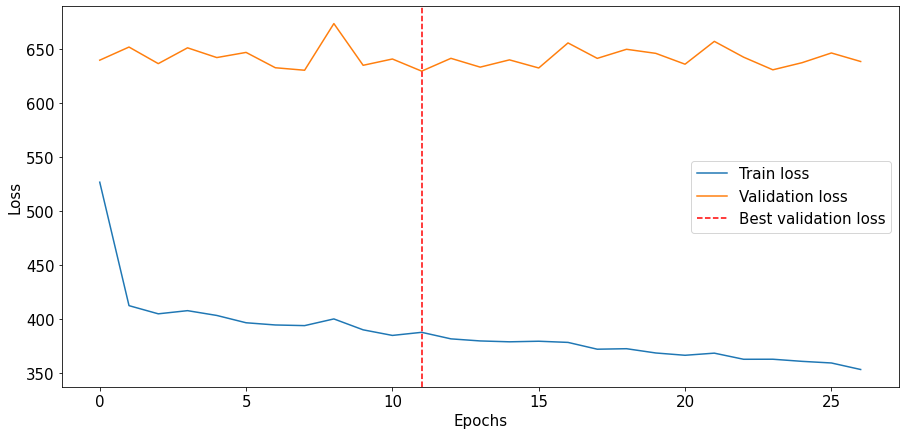

In [28]:
"Plot the train and validation loss of the previous training"
plot_loss_history(history)
# plt.savefig("num-nodules-regression-loss.pdf")

In [ ]:
# cnn = build_regression_model()
train_real_values = np.float32(
    [label.numpy()[0] for _, label in train_dataset.unbatch()]
)
train_real_values = (train_real_values - train_real_values.min()) / (
    train_real_values.max() - train_real_values.min()
)

train_predicted_values = np.float32(
    [
        cnn(x, training=False).numpy()[0][0]
        for x, _ in train_dataset.unbatch().batch(1).as_numpy_iterator()
    ]
)
train_predicted_values = (train_predicted_values - train_predicted_values.min()) / (
    train_predicted_values.max() - train_predicted_values.min()
)

val_real_values = np.float32([label.numpy()[0] for _, label in val_dataset.unbatch()])
val_real_values = (val_real_values - val_real_values.min()) / (
    val_real_values.max() - val_real_values.min()
)

val_predicted_values = np.float32(
    [
        cnn(x, training=False).numpy()[0][0]
        for x, _ in val_dataset.unbatch().batch(1).as_numpy_iterator()
    ]
)
val_predicted_values = (val_predicted_values - val_predicted_values.min()) / (
    val_predicted_values.max() - val_predicted_values.min()
)

In [ ]:
"Print the number of nodules and its regression prediction on the validation set"
# cnn = keras.models.load_model("models/")
for x, y in val_dataset.unbatch().batch(1).as_numpy_iterator():
    print(f"real: {y}")
    print(f"predicted: {cnn(x, training=False).numpy()}")
    print()

 Covid dataset

In [ ]:
neg_x = tfrecord_dataset([CT_0_TFRECORD])
# neg_samples = sum(1 for _ in tqdm(neg_x))
neg_samples = 254  # CT-0
print(f"{neg_samples = }")
neg_dataset = tf.data.Dataset.zip(
    (neg_x, tf.data.Dataset.from_tensor_slices(np.int8([[0]])).repeat(neg_samples))
)
# assert sum(1 for _ in tqdm(neg_dataset)) == neg_samples

pos_x = tfrecord_dataset([CT_1_TFRECORD, CT_2_TFRECORD, CT_3_TFRECORD, CT_4_TFRECORD])
# pos_samples = sum(1 for _ in tqdm(pos_x))
pos_samples = 856  # CT-1 + CT-2 + CT-3 + CT-4
# pos_samples = 127  # CT-2 + CT-3 + CT-4
print(f"{pos_samples = }")
pos_dataset = tf.data.Dataset.zip(
    (pos_x, tf.data.Dataset.from_tensor_slices(np.int8([[1]])).repeat(pos_samples))
)
# assert sum(1 for _ in tqdm(pos_dataset)) == pos_samples

covid_dataset = neg_dataset.concatenate(pos_dataset)
covid_samples = neg_samples + pos_samples
# assert sum(1 for _ in tqdm(covid_dataset)) == covid_samples
print(f"{covid_samples = }")
covid_dataset

In [ ]:
"""
Run this to have an idea of the elements of the covid_dataset.
At this point, covid_dataset is not shuffled, so the elements are
in order CT-0, CT-1, CT-2, CT-3, CT-4.

For example, to see a CT-2 scan you must run .skip(950)
"""
# scan, label = next(iter(covid_dataset.skip(0)))
# print(f"{label = }")
# plot_volume_animation(scan)

In [ ]:
def build_3d_cnn():
    model = keras.Sequential(
        [
            keras.layers.InputLayer(SCAN_SHAPE, name="input_layer"),
            SeluConv3D(filters=32, kernel_size=3, name="selu_conv3d_1"),
            keras.layers.MaxPool3D(2, name="maxpool3d_1"),
            SeluConv3D(filters=64, kernel_size=3, name="selu_conv3d_2"),
            keras.layers.MaxPool3D(2, name="maxpool3d_2"),
            SeluConv3D(filters=128, kernel_size=3, name="selu_conv3d_3"),
            keras.layers.MaxPool3D(2, name="maxpool3d_3"),
            SeluConv3D(filters=256, kernel_size=3, name="selu_conv3d_4"),
            keras.layers.MaxPool3D(2, name="maxpool3d_4"),
            keras.layers.Flatten(name="flatten"),
            keras.layers.Dense(1, activation="sigmoid", name="final_dense"),
        ],
        name="3d_cnn",
    )
    return model


m = build_3d_cnn()
m.summary()

In [ ]:
def build_pretrained_3d_cnn(freezing=True):
    pretrained_3d_cnn = keras.models.load_model("models/lidc-num-nodules-3dcnn.h5")
    pretrained_3d_cnn.pop()  # remove last dense layer
    model = keras.Sequential(
        [
            keras.layers.InputLayer(SCAN_SHAPE, name="pretrained_input"),
            pretrained_3d_cnn,
            keras.layers.Dense(1, activation="sigmoid", name="final_dense"),
        ],
        name="pretrained_3d_cnn",
    )
    pretrained_3d_cnn.trainable = not freezing
    return model


m = build_pretrained_3d_cnn()
m.summary()

In [ ]:
test_perc = 0.1
val_perc = 0.1
learning_rate = 1e-5
batch_size = 8
patience = 15

In [ ]:
trainval_dataset, test_dataset = train_test_split(
    covid_dataset, test_perc=test_perc, cardinality=covid_samples
)
train_dataset, val_dataset = train_test_split(trainval_dataset, test_perc=val_perc)
test_dataset = test_dataset.batch(1)
val_dataset = (
    val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset = (
    train_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [ ]:
"Train a model to predict covid/non-covid"
cnn = build_3d_cnn()
# cnn = build_pretrained_3d_cnn()
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.TruePositives(name="tp"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.AUC(name="auc"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)
history = cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True,
        ),
    ],
)

In [ ]:
plot_loss_history(history)

In [ ]:
print(cnn.evaluate(test_dataset, return_dict=True))

In [ ]:
rounds = 5
fracs = (1, 2, 5, 7, 10)
test_perc = 0.1
val_perc = 0.1
learning_rate = 1e-5
batch_size = 8
patience = 10
num_epochs = 1000
metrics = [
    keras.metrics.AUC(name="auc", num_thresholds=1000),
]

In [ ]:
"""
Train a model from scratch and a pre-trained model on the covid_dataset.

The models are trained on 1/`fracs` of the original covid_dataset.
The process is repeated r `rounds`.
"""
data = defaultdict(list)
wo_pt_histories = []
w_pt_histories = []
w_pt_freezing_histories = []
for r in tqdm(range(rounds)):
    print(f" {r = } ".center(50, "="))
    full_train_dataset, test_dataset = train_test_split(
        covid_dataset, test_perc=test_perc, cardinality=covid_samples
    )
    # print(f"Test size: {sum(1 for _ in test_dataset)}")
    test_dataset = test_dataset.batch(batch_size)
    full_train_dataset, val_dataset = train_test_split(
        full_train_dataset, test_perc=val_perc
    )
    # print(f"Val size: {sum(1 for _ in val_dataset)}")
    val_dataset = val_dataset.batch(batch_size)
    wo_pt_frac_histories = []
    w_pt_frac_histories = []
    w_pt_freezing_frac_histories = []
    for frac in fracs:
        print(f" {frac = } ".center(25, "="))
        train_dataset = (
            full_train_dataset.shuffle(1024, reshuffle_each_iteration=False)
            .shard(num_shards=frac, index=0)
            .cache()  # must be called before shuffle
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )
        # print(f"Train size: {sum(1 for _ in train_dataset.unbatch())}")

        cnn = build_3d_cnn()
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )
        history = cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    restore_best_weights=True,
                )
            ],
        )
        wo_pt_frac_histories.append(history)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        wo_pt_auc = test_metrics["auc"]
        print(f"{wo_pt_auc = }")
        data["nn_type"].append("w/o pre-training")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(wo_pt_auc)

        cnn = build_pretrained_3d_cnn(freezing=False)
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )
        history = cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    restore_best_weights=True,
                )
            ],
        )
        w_pt_frac_histories.append(history)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        w_pt_auc = test_metrics["auc"]
        print(f"{w_pt_auc = }")
        data["nn_type"].append("w/ pre-training (w/o freezing)")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(w_pt_auc)

    wo_pt_histories.append(wo_pt_frac_histories)
    w_pt_histories.append(w_pt_frac_histories)

In [ ]:
"Plot the results of the previous trainings"
g = sns.catplot(
    x="train_size_fraction",
    y="metric_value",
    col="metric",
    hue="nn_type",
    kind="point",
    data=pd.DataFrame(data),
)
# for ax in g.axes[0]:
#    ax.axhline(color="r", ls="--")

In [ ]:
round_index = 0
frac_index = 0
plt.plot(
    wo_pt_histories[round_index][frac_index].history["loss"],
    "--",
    label="w/o pre-training - train loss",
)
plt.plot(
    wo_pt_histories[round_index][frac_index].history["val_loss"],
    label="w/o pre-training - val loss",
)
plt.plot(
    w_pt_histories[round_index][frac_index].history["loss"],
    "--",
    label="w/ pre-training, w/o conv freezing - train loss",
)
plt.plot(
    w_pt_histories[round_index][frac_index].history["val_loss"],
    label="w/ pre-training, w/o conv freezing - val loss",
)
# plt.plot(
#    w_pt_freezing_histories[round_index][frac_index].history["loss"],
#    "--",
#    label="w/ pre-training, w/ conv freezing - train loss",
# )
# plt.plot(
#    w_pt_freezing_histories[round_index][frac_index].history["val_loss"],
#    label="w/ pre-training, w/ conv freezing - val loss",
# )
plt.legend()

In [ ]:
data = defaultdict(list)
wo_pt_histories = []
w_pt_histories = []
for _ in tqdm(range(rounds)):
    trainval_dataset, test_dataset = train_test_split(
        covid_dataset, test_perc=test_perc, cardinality=covid_samples
    )
    test_dataset = test_dataset.batch(batch_size)
    full_train_dataset, val_dataset = train_test_split(
        trainval_dataset, test_perc=val_perc
    )
    val_dataset = val_dataset.batch(batch_size)
    wo_pt_frac_histories = []
    w_pt_frac_histories = []
    for frac in fracs:
        train_dataset = (
            full_train_dataset.shuffle(1024, reshuffle_each_iteration=False)
            .shard(num_shards=frac, index=0)
            .cache()  # must be called before shuffle
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )

        cnn = build_3d_cnn()
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )
        history = cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    restore_best_weights=True,
                )
            ],
        )
        wo_pt_frac_histories.append(history)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("w/o pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])

        cnn = build_pretrained_3d_cnn(True)
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )
        history = cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    restore_best_weights=True,
                )
            ],
        )
        w_pt_frac_histories.append(history)
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("w/ pretraining (conv freezing)")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])
    wo_pt_histories.append(wo_pt_frac_histories)
    w_pt_histories.append(w_pt_frac_histories)

In [ ]:
sns.catplot(
    x="train_size_fraction",
    y="metric_value",
    hue="nn_type",
    col="metric",
    kind="point",
    data=pd.DataFrame(data),
)

In [ ]:
round_index = 1
frac_index = 0
plt.plot(
    wo_pt_histories[round_index][frac_index].history["loss"],
    "--",
    label="w/o pre-training - train loss",
)
plt.plot(
    wo_pt_histories[round_index][frac_index].history["val_loss"],
    label="w/o pre-training - val loss",
)
plt.plot(
    w_pt_histories[round_index][frac_index].history["loss"],
    "--",
    label="w/ pre-training, w/ conv freezing - train loss",
)
plt.plot(
    w_pt_histories[round_index][frac_index].history["val_loss"],
    label="w/ pre-training, w/ conv freezing - val loss",
)
plt.legend()

In [ ]:
k = 10
val_perc = 0.1
learning_rate = 1e-5
batch_size = 8
patience = 10
num_epochs = 1000

In [ ]:
wo_pt_histories = []
wo_pt_metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc", num_thresholds=1000),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]
w_pt_histories = []
w_pt_metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc", num_thresholds=1000),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]
for fold_id, (train_dataset, test_dataset) in tqdm(
    enumerate(kfolds(k, covid_dataset, cardinality=covid_samples)), total=k
):
    test_dataset = test_dataset.batch(1)
    train_dataset, val_dataset = train_test_split(train_dataset, test_perc=val_perc)
    val_dataset = val_dataset.batch(batch_size)
    train_dataset = (
        train_dataset.cache()  # must be called before shuffle
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

    cnn = build_3d_cnn()
    cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        verbose=1,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True,
            )
        ],
    )
    wo_pt_histories.append(history)
    for test_x, test_y in test_dataset.as_numpy_iterator():
        pred_y = cnn(test_x, training=False)
        for metric in wo_pt_metrics:
            metric.update_state(test_y, pred_y)

    cnn = build_pretrained_3d_cnn(True)
    cnn.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss=keras.losses.BinaryCrossentropy(),
    )
    history = cnn.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True,
            )
        ],
    )
    w_pt_histories.append(history)
    for test_x, test_y in test_dataset.as_numpy_iterator():
        pred_y = cnn(test_x, training=False)
        for metric in w_pt_metrics:
            metric.update_state(test_y, pred_y)

print(" total ".center(50, "="))
print("Without pretraining: ")
for metric in wo_pt_metrics:
    print(f"{metric.name}: {metric.result()}")
print("")

print("With pretraining (w/ conv freezing): ")
for metric in w_pt_metrics:
    print(f"{metric.name}: {metric.result()}")

In [ ]:
index = 0
plt.plot(
    wo_pt_histories[index].history["loss"], "--", label="w/o pre-training - train loss"
)
plt.plot(
    wo_pt_histories[index].history["val_loss"], label="w/o pre-training - val loss"
)
plt.plot(
    w_pt_histories[index].history["loss"],
    "--",
    label="w/ pre-training, w/o conv freezing - train loss",
)
plt.plot(
    w_pt_histories[index].history["val_loss"],
    label="w/ pre-training, w/o conv freezing - val loss",
)
plt.plot(
    w_pt_conv_histories[index].history["loss"],
    "--",
    label="w/ pre-training, w/ conv freezing - train loss",
)
plt.plot(
    w_pt_conv_histories[index].history["val_loss"],
    label="w/ pre-training, w/ conv freezing - val loss",
)
plt.legend()